In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys, os, pathlib
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import pandas as pd
import nibabel as nib
import torch

sys.path.append('../..')
import project

torch.cuda.is_available()

True

In [3]:
# nb configuration
data_root = pathlib.Path('/ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene')
data_file = data_root / 'sample1000_2025-07-22.csv'
example_idx = 0
source_state = 'INSP'
target_state = 'EXP'

In [4]:
df = pd.read_csv(data_file, sep='\t', low_memory=False)
dataset = project.copdgene.COPDGeneDataset(df, data_root)
row, visit = dataset[example_idx]
row

sid               16514P
ccenter              TEM
kernel               STD
Emphysema              0
pctEmph           0.3373
pctEmph_Slicer    0.3147
FEV1pp_utah         77.6
FVCpp_utah          88.9
FEV1_FVC_utah       0.71
finalGold           -1.0
catEmph           normal
Name: 0, dtype: object

In [7]:
def voxel_to_world_coords(points, affine):
    assert points.ndim == 2 and points.shape[1] == 3
    assert affine.shape == (4, 4) and np.allclose(affine[3], [0,0,0,1])
    points_h = np.c_[points, np.ones(points.shape[0])]
    return (affine @ points_h.T).T[:,:3]

def world_to_voxel_coords(points, affine):
    assert points.ndim == 2 and points.shape[1] == 3
    assert affine.shape == (4, 4) and np.allclose(affine[3], [0,0,0,1])
    points_h = np.c_[points, np.ones(points.shape[0])]
    return np.linalg.solve(affine, points_h.T).T[:,:3]


In [12]:
def get_header_info(nifti):
    shape = np.asarray(nifti.header.get_data_shape())
    zooms = np.asarray(nifti.header.get_zooms())

    steps = nifti.affine[:3,:3].copy()
    origin = nifti.affine[:3,3].copy()
    axcodes = nib.orientations.aff2axcodes(nifti.affine)

    center_ijk = (shape[:3] - 1) / 2
    center_xyz = voxel_to_world_coords(center_ijk[None,:], nifti.affine)[0]

    # compute bbox of voxel centers from corner voxels
    i_bounds = [0, shape[0] - 1]
    j_bounds = [0, shape[1] - 1]
    k_bounds = [0, shape[2] - 1]
    I, J, K = np.meshgrid(i_bounds, j_bounds, k_bounds, indexing='ij')
    corners_ijk = np.stack([I, J, K], axis=-1).reshape(-1, 3)
    corners_xyz = voxel_to_world_coords(corners_ijk, nifti.affine)
    
    bbox_min = corners_xyz.min(axis=0)
    bbox_max = corners_xyz.max(axis=0)
    lengths = (shape - 1) * zooms

    return {
        'shape': tuple(shape),
        'zooms': tuple(zooms),
        'axcodes': axcodes,
        'origin': tuple(origin),
        'center': tuple(center_xyz),
        'steps': steps,
        'bbox_min': tuple(bbox_min),
        'bbox_max': tuple(bbox_max),
        'lengths': tuple(lengths)
    }

def get_center(image):
    size = np.array(image.GetSize(), dtype=int)
    spacing = np.array(image.GetSpacing(), dtype=float)
    origin = np.array(image.GetOrigin(), dtype=float)
    D = np.array(image.GetDirection(), dtype=float).reshape(3, 3)
    return origin + D @ (spacing * (size - 1) / 2)


In [13]:
%autoreload
image_nifti = visit.load_image(variant='RAW', state='EXP', recon='STD')
get_header_info(image_nifti)

{'shape': (512, 512, 537),
 'zooms': (0.71875, 0.71875, 0.5),
 'axcodes': ('L', 'A', 'S'),
 'origin': (167.640625, -6.640625, -319.0),
 'center': (-16.0, 177.0, -185.0),
 'steps': array([[-0.71875, -0.     ,  0.     ],
        [ 0.     ,  0.71875,  0.     ],
        [ 0.     ,  0.     ,  0.5    ]]),
 'bbox_min': (-199.640625, -6.640625, -319.0),
 'bbox_max': (167.640625, 360.640625, -51.0),
 'lengths': (367.28125, 367.28125, 268.0)}

# Preprocessing

In [14]:
%autoreload
visit.resample_images()

[16514P_EXP_STD_TEM_COPD] Creating reference grid
[16514P_EXP_STD_TEM_COPD] Resampling image on reference grid
[16514P_INSP_STD_TEM_COPD] Resampling image on reference grid


In [15]:
%autoreload
visit.create_segmentation_masks(state=source_state)
visit.create_segmentation_masks(state=target_state)

[16514P_INSP_STD_TEM_COPD] Running segmentation task: total

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough segmentation for cropping...
Resampling...
  Resampled in 0.89s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/inference/predict_from_raw_data.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimen

  Predicted in 104.00s
Resampling...
  cropping from (368, 368, 269) to (297, 236, 259)
Resampling...
  Resampled in 1.99s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:01<00:00,  5.70it/s]


  Predicted in 12.84s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 2.13s
[16514P_INSP_STD_TEM_COPD] Running segmentation task: lung_vessels

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough segmentation for cropping...
Resampling...
  Resampled in 0.87s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/inference/predict_from_raw_data.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimen

  Predicted in 9.03s
Resampling...
  cropping from (368, 368, 269) to (297, 236, 259)
Predicting...


100%|██████████| 80/80 [00:05<00:00, 13.71it/s]


  Predicted in 32.94s
Saving segmentations...


  0%|          | 0/2 [00:00<?, ?it/s]

Creating lung_vessels.nii.gzCreating lung_trachea_bronchia.nii.gz

  Saved in 1.55s
[16514P_INSP_STD_TEM_COPD] Combining segmentation masks: lung
[16514P_EXP_STD_TEM_COPD] Running segmentation task: total

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough segmentation for cropping...
Resampling...
  Resampled in 0.87s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/inference/predict_from_raw_data.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimen

  Predicted in 8.34s
Resampling...
  cropping from (368, 368, 269) to (278, 224, 229)
Resampling...
  Resampled in 1.57s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 32.03it/s]


  Predicted in 9.93s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 1.95s
[16514P_EXP_STD_TEM_COPD] Running segmentation task: lung_vessels

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough segmentation for cropping...
Resampling...
  Resampled in 0.87s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/inference/predict_from_raw_data.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimen

  Predicted in 8.22s
Resampling...
  cropping from (368, 368, 269) to (278, 224, 229)
Predicting...


100%|██████████| 60/60 [00:03<00:00, 18.38it/s]


  Predicted in 25.96s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 1.53s
[16514P_EXP_STD_TEM_COPD] Combining segmentation masks: lung


In [37]:
%autoreload
visit.create_multi_region_mask(state=source_state)
visit.create_multi_region_mask(state=target_state)

[16514P_EXP_STD_TEM_COPD] Processing roi mask: lung_upper_lobe_right
  # 1-connected inputs components: 4
    72 voxels were dropped (0.0168%)
  # 1-connected output components: 1
[16514P_EXP_STD_TEM_COPD] Processing roi mask: lung_middle_lobe_right
  # 1-connected inputs components: 1
    0 voxels were dropped (0.0000%)
  # 1-connected output components: 1
[16514P_EXP_STD_TEM_COPD] Processing roi mask: lung_lower_lobe_right
  # 1-connected inputs components: 5
    15 voxels were dropped (0.0031%)
  # 1-connected output components: 1
[16514P_EXP_STD_TEM_COPD] Processing roi mask: lung_upper_lobe_left
  # 1-connected inputs components: 2
    2 voxels were dropped (0.0004%)
  # 1-connected output components: 1
[16514P_EXP_STD_TEM_COPD] Processing roi mask: lung_lower_lobe_left
  # 1-connected inputs components: 2
    4 voxels were dropped (0.0009%)
  # 1-connected output components: 1
[16514P_EXP_STD_TEM_COPD] Processing roi mask: lung_trachea_bronchia
  # 1-connected inputs components: 

In [38]:
%autoreload
visit.create_anatomical_mesh(
    state=target_state,
    max_facet_distance=1.0,
    max_cell_circumradius=20.0,
    seed=0
)[0]

[16514P_EXP_STD_TEM_COPD] Creating anatomical mesh
Removed 0 unused points
Final mesh:  <meshio mesh object>
  Number of points: 17314
  Number of cells:
    triangle: 61764
    tetra: 88042
  Cell data: label
Mesh has 1 connected component(s)
[16514P_EXP_STD_TEM_COPD] Applying affine to mesh


In [39]:
visit.create_anatomical_mesh(
    state=source_state,
    max_facet_distance=1.0,
    max_cell_circumradius=20.0,
    seed=0
)[0]

[16514P_INSP_STD_TEM_COPD] Creating anatomical mesh
Removed 1 unused points
Final mesh:  <meshio mesh object>
  Number of points: 17655
  Number of cells:
    triangle: 60614
    tetra: 86659
  Cell data: label
Mesh has 1 connected component(s)
[16514P_INSP_STD_TEM_COPD] Applying affine to mesh


In [40]:
%autoreload
visit.create_displacement_field()

[16514P_INSP_STD_TEM_COPD -> 16514P_EXP_STD_TEM_COPD] Creating displacement field
Compute fixed MIND features ... 

/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538438429/work/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


finished (12.71 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.24 s).
    1752 fixed keypoints extracted (2.09 s).
    Compute forward marginals ... 

/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/copdgene/../../corrfield/graphs.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538438429/work/torch/csrc/utils/tensor_new.cpp:278.)
  edges = torch.tensor(


finished (3.35 s).
    Compute symmetric backward marginals ... finished (1.22 s).
    Dense thin plate spline interpolation ... finished (20.33 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.26 s).
    3462 fixed keypoints extracted (0.19 s).
    Compute forward marginals ... finished (0.87 s).
    Compute symmetric backward marginals ... finished (0.95 s).
    Dense thin plate spline interpolation ... finished (1.18 s).

tensor(0.3882, device='cuda:0')
tensor(0.2261, device='cuda:0')


# Visualization

In [41]:
source_image = visit.load_image(variant='ISO', state=source_state, recon='STD')
target_image = visit.load_image(variant='ISO', state=target_state, recon='STD')

mask_image_s = visit.load_mask(variant='ISO', state=source_state, recon='STD', mask_name='lung_regions')
mask_image_t = visit.load_mask(variant='ISO', state=target_state, recon='STD', mask_name='lung_regions')

disp_image = visit.load_displacement_field(
    variant='ISO', target_state=target_state, source_state=source_state, recon='STD'
)
source_mesh = visit.load_mesh(
    variant='ISO', state=source_state, recon='STD', mask_name='lung_regions', mesh_tag='surface'
)
target_mesh = visit.load_mesh(
    variant='ISO', state=target_state, recon='STD', mask_name='lung_regions', mesh_tag='surface'
)

In [42]:
source_array = source_image.get_fdata()
target_array = target_image.get_fdata()

mask_array_s = mask_image_s.get_fdata()
mask_array_t = mask_image_t.get_fdata()

disp_array = disp_image.get_fdata()

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt

def subplot_grid(
    n_rows, n_cols, ax_height, ax_width, spacing=0, pad=0, cbar_width=0, **subplot_kws):
    '''
    A wrapper around the plt.subplots function that enables more precise control
    over the figure size and layout.
    
    Instead of specifying the figure size and computing the grid layout relative to it,
    you provide the axes sizes, spacing, and padding, and the figure size is computed.

    Args:
        n_rows: int
        n_cols: int
        ax_height: float or iterable of floats
        ax_width: float or iterable of floats
        cbar_width: float (optional)
        spacing: (vertical, horizontal)
        pad: (left, right, bottom, top)

    Returns:
        (fig, axes) or (fig, axes, cbar_ax)
    '''
    ax_heights = as_iterable(ax_height, length=n_rows)
    ax_widths  = as_iterable(ax_width,  length=n_cols)

    h_spacing, w_spacing = as_iterable(spacing, length=2)
    l_pad, r_pad, b_pad, t_pad = as_iterable(pad, length=4)

    assert len(ax_heights) == n_rows
    assert len(ax_widths)  == n_cols

    total_ax_height = sum(ax_heights)
    total_ax_width  = sum(ax_widths)

    total_h_spacing = (n_rows - 1) * h_spacing 
    total_w_spacing = (n_cols - 1) * w_spacing

    fig_height = total_ax_height + total_h_spacing + b_pad + t_pad
    fig_width  = total_ax_width  + total_w_spacing + l_pad + r_pad

    extra_width = 0
    if cbar_width > 0:
        extra_width = cbar_width + w_spacing
        fig_width += extra_width

    mean_ax_height = total_ax_height / n_rows
    mean_ax_width  = total_ax_width  / n_cols

    gridspec_kws = {
        'height_ratios': ax_heights,
        'width_ratios':  ax_widths,
        'hspace': h_spacing / mean_ax_height,
        'wspace': w_spacing / mean_ax_width,
        'left': l_pad / fig_width,
        'right': 1.0 - (r_pad + extra_width) / fig_width,
        'bottom': b_pad / fig_height,
        'top': 1.0 - t_pad / fig_height
    }
    fig, axes = plt.subplots(
        n_rows, n_cols, squeeze=False,
        figsize=(fig_width, fig_height),
        gridspec_kw=gridspec_kws,
        **subplot_kws
    )

    if cbar_width > 0:
        cbar_left = total_ax_width + total_w_spacing + l_pad
        cbar_bottom = b_pad
        cbar_height = 1.0 - (b_pad + t_padding)
        cbar_ax = fig.add_axes([
            cbar_left   / fig_width,
            cbar_bottom / fig_height,
            cbar_width  / fig_width,
            cbar_height / fig_height
        ])
        return fig, axes, cbar_ax
    else:
        return fig, axes

def as_iterable(obj, length=1, string_ok=False):
    if not is_iterable(obj, string_ok):
        return [obj] * length
    return obj

def is_iterable(obj, string_ok=False):
    if isinstance(obj, str):
        return string_ok
    return hasattr(obj, '__iter__')


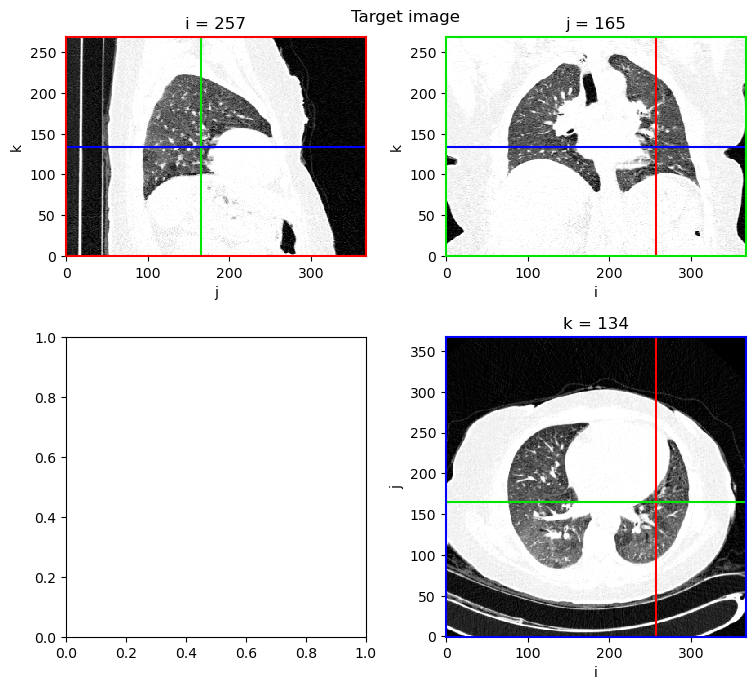

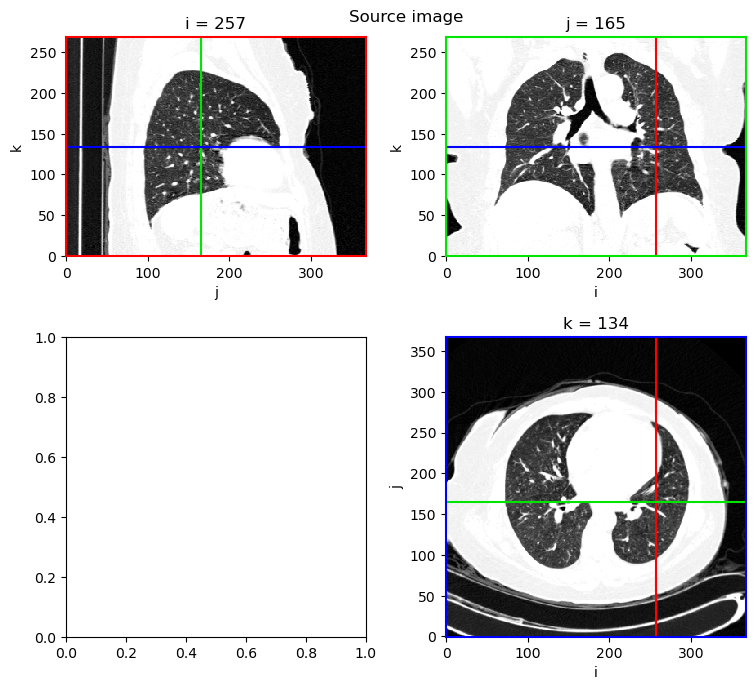

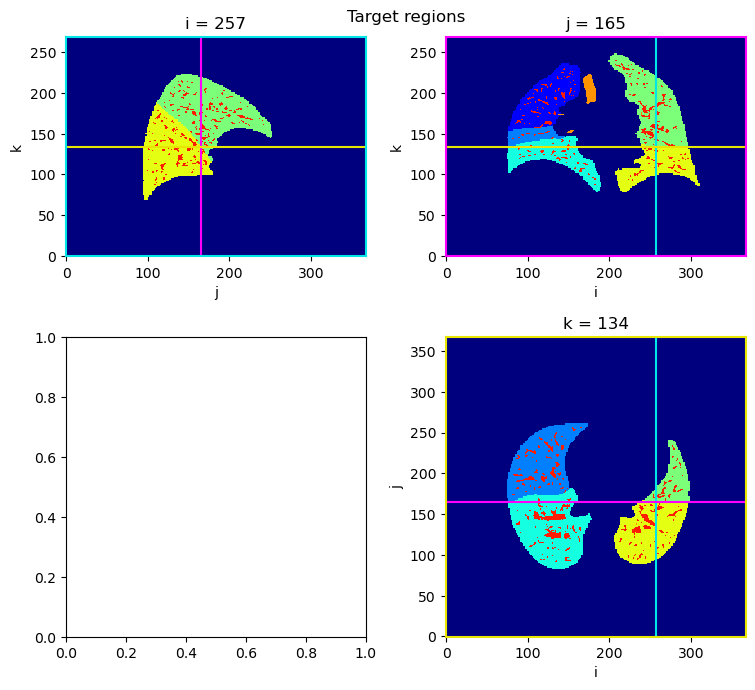

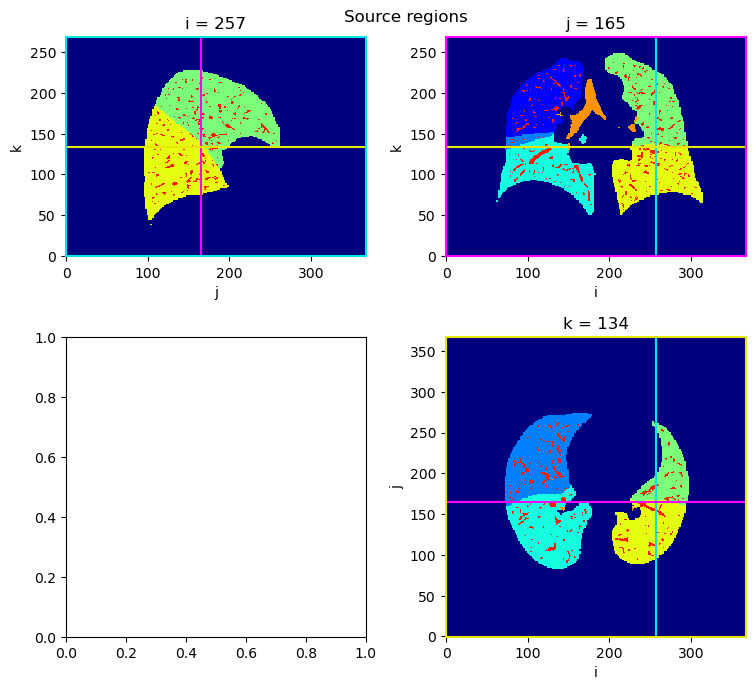

In [44]:
def show_image_slices(array, idx, imshow_kws=None, line_kws=None, title=None, colors='rgb'):
    assert array.ndim == 3 and len(idx) == 3
    
    i, j, k = idx
    i = fractional_index(i, array.shape[0])
    j = fractional_index(j, array.shape[1])
    k = fractional_index(k, array.shape[2])

    imshow_kws = with_defaults(imshow_kws, interpolation='none')
    
    color_dict = get_color_dict(brightness=0.5, saturation=1.0)
    colors = as_iterable(colors, length=3, string_ok=True)
    colors = [color_dict.get(c, c) for c in colors]

    i_line_kws = with_defaults(line_kws, color=colors[0], linewidth=1.5)
    j_line_kws = with_defaults(line_kws, color=colors[1], linewidth=1.5)
    k_line_kws = with_defaults(line_kws, color=colors[2], linewidth=1.5)
  
    fig, axes = subplot_grid(2, 2, ax_height=3, ax_width=3, spacing=(0.4, 0.8))
    fig.suptitle(title)

    ax = axes[0,0]
    ax.imshow(array[i,:,:].T, origin='lower', **imshow_kws)
    set_ax_spine_props(ax, **i_line_kws)
    ax.axvline(j, **j_line_kws)
    ax.axhline(k, **k_line_kws)
    ax.set_xlabel('j')
    ax.set_ylabel('k')
    ax.set_title(f'i = {i}')

    ax = axes[0,1]
    ax.imshow(array[:,j,:].T, origin='lower', **imshow_kws)
    set_ax_spine_props(ax, **j_line_kws)
    ax.axvline(i, **i_line_kws)
    ax.axhline(k, **k_line_kws)
    ax.set_xlabel('i')
    ax.set_ylabel('k')
    ax.set_title(f'j = {j}')

    ax = axes[1,1]
    ax.imshow(array[:,:,k].T, origin='lower', **imshow_kws)
    set_ax_spine_props(ax, **k_line_kws)
    ax.axvline(i, **i_line_kws)
    ax.axhline(j, **j_line_kws)
    ax.set_xlabel('i')
    ax.set_ylabel('j')
    ax.set_title(f'k = {k}')

def fractional_index(idx, length):
    if isinstance(idx, float):
        return int(round(idx * (length - 1)))
    return idx

def get_color_dict(brightness=0.5, saturation=1.0):
    l = max(brightness - saturation / 2, 0)
    h = min(brightness + saturation / 2, 1)
    m = h * 0.9 + l * 0.1
    return {
        'r': (h,l,l),
        'g': (l,m,l),
        'b': (l,l,h),
        'c': (l,m,m),
        'm': (h,l,h),
        'y': (m,m,l),
        'w': (h,h,h),
        'k': (l,l,l),
    }

def with_defaults(overrides=None, **defaults):
    return defaults | (overrides or {})

def set_ax_spine_props(ax, color, linewidth):
    for spine in ['left', 'right', 'top', 'bottom']:
        ax.spines[spine].set_color(color)
        ax.spines[spine].set_linewidth(linewidth)

idx = (0.7, 0.45, 0.5)
show_image_slices(target_array, idx, imshow_kws=dict(cmap='Greys_r', vmin=-1024, vmax=0), title='Target image', colors='rgb')
show_image_slices(source_array, idx, imshow_kws=dict(cmap='Greys_r', vmin=-1024, vmax=0), title='Source image', colors='rgb')
show_image_slices(mask_array_t, idx, imshow_kws=dict(cmap='jet', vmin=0, vmax=8), title='Target regions', colors='cmy')
show_image_slices(mask_array_s, idx, imshow_kws=dict(cmap='jet', vmin=0, vmax=8), title='Source regions', colors='cmy')

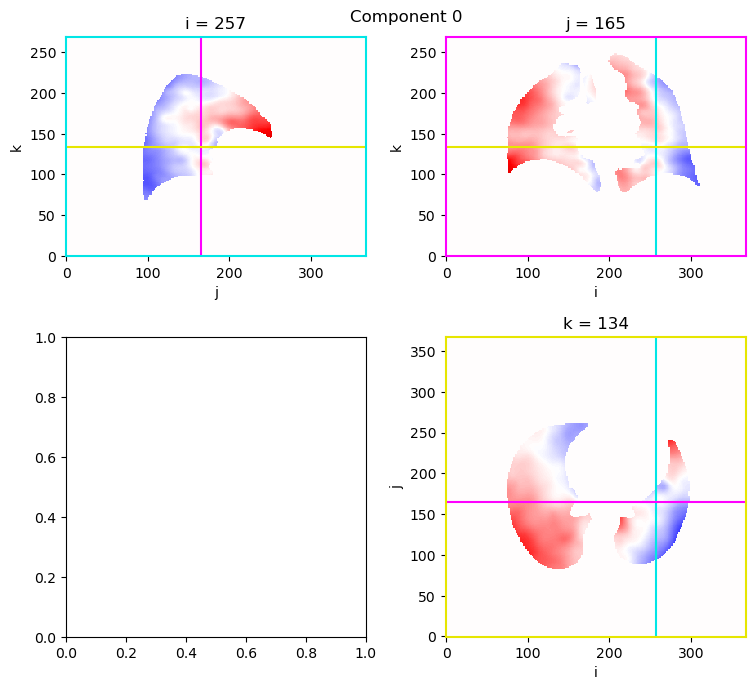

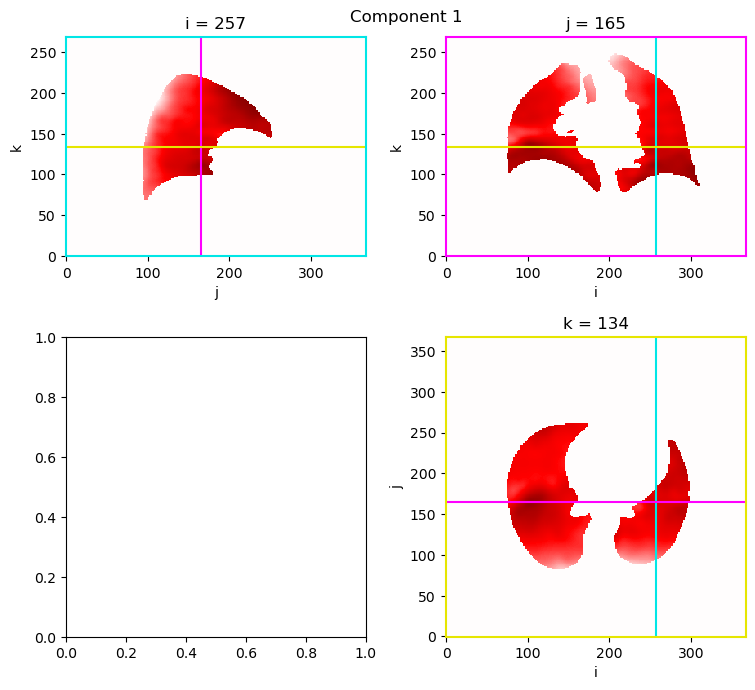

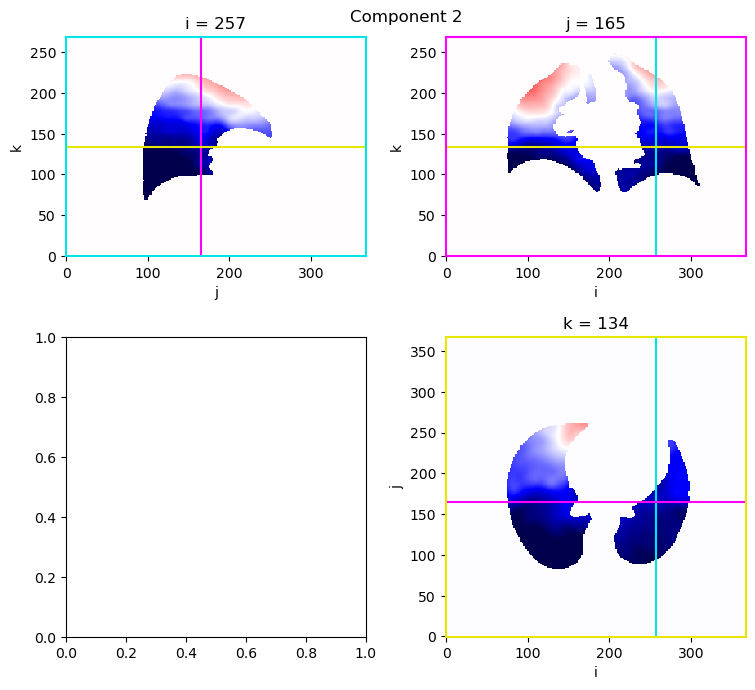

In [45]:
alpha = 1
m = (mask_array_t > 0) * alpha + (1 - alpha)
show_image_slices(disp_array[...,0] * m, idx, imshow_kws=dict(cmap='seismic', vmin=-20, vmax=20), title='Component 0', colors='cmy')
show_image_slices(disp_array[...,1] * m, idx, imshow_kws=dict(cmap='seismic', vmin=-20, vmax=20), title='Component 1', colors='cmy')
show_image_slices(disp_array[...,2] * m, idx, imshow_kws=dict(cmap='seismic', vmin=-20, vmax=20), title='Component 2', colors='cmy')

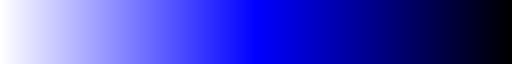

In [61]:
import matplotlib

nneg_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    name='nonnegative',
    colors=[
        (1,1,1),
        (0,0,1),
        (0,0,0),
    ]
)
nneg_cmap.set_under('red')
nneg_cmap

lungs:   282.97998046875
airways: 33.13043212890621
vessels: 643.5667724609375


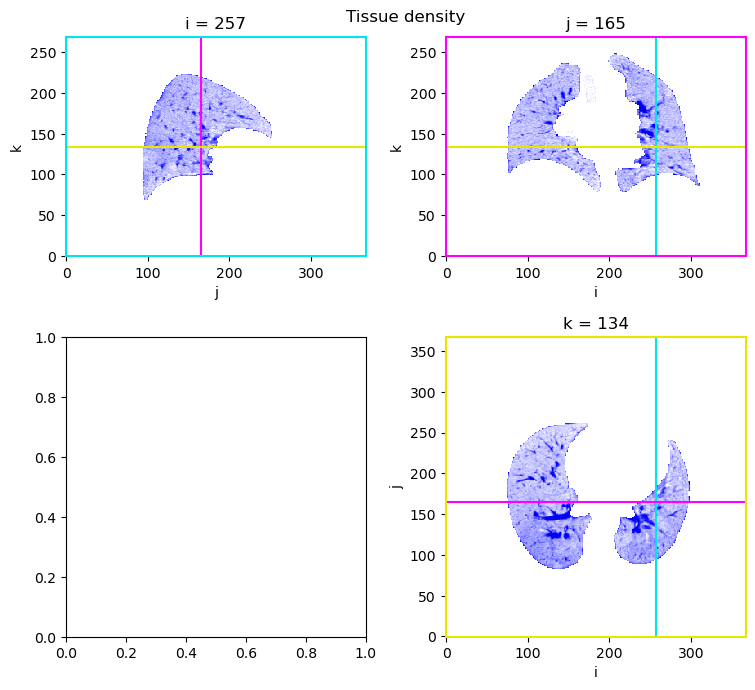

In [74]:
%autoreload

density_array = project.segmentation.compute_density_map(target_array, mask_array_t, use_ct=1, use_mask=0)

alpha = 1
m = (mask_array_t > 0) * alpha + (1 - alpha)

show_image_slices(density_array * m, idx, imshow_kws=dict(cmap=nneg_cmap, vmin=0, vmax=2000), title='Tissue density', colors='cmy')